In [1]:
from Functions import *
import winsound

In [2]:
''' Beam parameters '''
N = 1024			# number of sampling points
E0 = 9481			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 50000		# total simulation time window [fs]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 650-26
}

In [3]:
##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'beam_profiles/'; make_dir(dir_case)

print('\nCWD:',dir_case)

path exists
path exists
path exists

CWD: output/9481eV/beam_profiles/


In [4]:
def define_beamline(
    E0, m1_p=185.0, m2_p=175.5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 9.0,
    hkl2 = [3,3,3], alphaAsym2 = 0.0,
    hkl3 = [4,4,0], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=512)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m2_p=m2_p)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline


### Setup beamline and calculate beam profiles at each optics to determine the crystal profiles

In [5]:
##### perfect case
m1_p = 185.0; m2_p = 175.823
slit_width = 1e-1; if_close = 0
f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 9.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [2,2,0]; alphaAsym2 = 16.9    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [4,4,0]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices, mono_beamline = define_beamline(E0,
                               m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

dir_plot = dir_case+'{}_{}_{}/'.format(HHLM_type, hkl1[0]*100+hkl1[1]*10+hkl1[2],
                                      hkl2[0]*100+hkl2[1]*10+hkl2[2]); make_dir(dir_plot)

dir_plot += '{}_{}_deg_{}mm_offset'.format(alphaAsym1, alphaAsym2, 1e3*HHLM_offset)
if if_close == 0:
    dir_plot += '_open/'
else:
    dir_plot += '_close/'
make_dir(dir_plot)

b 0.15
b 6.76
b 0.09
b 11.36
b 1.00
b 1.81
slit width: 100000.0 um
b 0.55
b 1.00
path exists
make path


In [6]:
beam_offsets = []
for device in mono_devices:
    if not device.name.startswith('im_'):
        print(device.name)
        print('  x:{}, y:{}, z:{}\n'.format(device.global_x, device.global_y, device.z))
    if device.name == 'HHLM1':
        beam_offsets.append(device.global_x)
    if device.name == 'HHLM2':
        beam_offsets.append(device.global_x)

beam_offset = (beam_offsets[-1]-beam_offsets[0])*1e3
print('beam_offset: {}mm'.format(beam_offset, 2))
print('distance factor for 20mm: {}'.format(20/beam_offset))

M1
  x:0.0, y:0.0, z:835

M2
  x:0.6095057070157908, y:0.0, z:950

HHLM1
  x:0.6095057070157908, y:0.0, z:955

HHLM2
  x:0.629500629189023, y:0.0, z:955.0447418815587

HHLM3
  x:0.6294910888778436, y:0.0, z:955.2447418815588

HHLM4
  x:0.6094935171522792, y:0.0, z:955.268719890932

C1
  x:0.609922137296546, y:0.0, z:960

C2
  x:1.3010333554349383, y:0.0, z:960.05

mir1
  x:1.301664957849692, y:0.0, z:970.05

Slit
  x:1.3742978374808894, y:0.0, z:980.05

mir2
  x:1.4469307171120867, y:0.0, z:990.05

C3
  x:1.4475623195268403, y:0.0, z:1000.05

C4
  x:0.6142054156681063, y:0.0, z:1000.1104300188617

beam_offset: 19.99492217323229mm
distance factor for 20mm: 1.0002539558155674


In [7]:
%%capture capt
# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)


wx1, wy1 = mono_beamline.im_after_HHLM1.beam_analysis(mono_beamline.im_after_HHLM1.get_profile_x(), mono_beamline.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline.im_after_HHLM2.beam_analysis(mono_beamline.im_after_HHLM2.get_profile_x(), mono_beamline.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline.im_after_HHLM3.beam_analysis(mono_beamline.im_after_HHLM3.get_profile_x(), mono_beamline.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline.im_after_HHLM4.beam_analysis(mono_beamline.im_after_HHLM4.get_profile_x(), mono_beamline.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline.im_after_C1.beam_analysis(mono_beamline.im_after_C1.get_profile_x(), mono_beamline.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline.im_after_C2.beam_analysis(mono_beamline.im_after_C2.get_profile_x(), mono_beamline.im_after_C2.get_profile_y())[2:4]

beta0s = []
for device in mono_devices:
    if device.name in crystals:
        beta0s.append(device.beta0)

# crystal lengths (long) and widths (short) [m]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2


In [8]:
##### calculate crystal properties to calculate beam power
braggs = []
asyms = []

for device in mono_devices:
    if device.name in crystals:
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))
print('beam size[mm]: {}'.format(beam_size*1e3))
print('bragg angle', np.round(braggs,3))
print('asymmetry', asyms)
print('footprint [mm]',l_crystal*1e3/2)

beam size[mm]: [ 8.8554952   1.31030026 14.92133886  1.31338177  1.31317235  0.72597504]
bragg angle [12.043 12.037 19.916 19.91  42.928 42.928]
asymmetry [-9.0, 9.0, -16.9, 16.9, 0.0, 14.999999999999998]
footprint [mm] [24.66901074 24.66744596 24.90388751 24.90457133  1.92806209  1.54992249]


### Calculate slit width

In [9]:
%%capture capt
mono_devices, mono_beamline = define_beamline(E0,
                               m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=[None for i in range(6)],
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

''' propagate '''
beam_params['photonEnergy'] = E0
b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)


In [10]:
def calc_slit_width(inbeam, lmbd, foc):
    # inbeam is the beamsize (2x FWHM) after Crystal 2
    # lmbd is wavelength of photon
    # asym is asymmetry angle of Crystal 2
    # foc is Mir1/Lens1 focal distance
    # returns mono focus size in [m] at the Fourier plane
    slt = 2*np.log(2)*lmbd*foc/np.pi/inbeam
    return 2.11 * slt    # 2x FWHM with some error (~factor of 5%)

wx = mono_beamline.im_after_C2.beam_analysis(mono_beamline.im_after_C2.get_profile_x(), mono_beamline.im_after_C2.get_profile_y())[2]
slit_width = calc_slit_width(wx*2, b2.lambda0, mono_beamline.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6:
    slit_width = 3e-6

if if_close == 0:
    slit_width = 1e-1
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))


calculated slit width: 0.84um
actual slit width: 100000.0um



### Beam profiles for the perfect case

In [11]:
%%capture capt

mono_devices, mono_beamline = define_beamline(E0,
                           m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                           slit_width=slit_width, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           hkl3=hkl3, alphaAsym3=alphaAsym3,
                           shapeErrors=[None for i in range(6)],
                           l_crystal=l_crystal,
                           w_crystal=w_crystal)

screen_names = ['im_input', 'im_after_T1', 'im_after_T2', 'im_after_HHLM1', 'im_after_HHLM2', 'im_after_HHLM3', 'im_after_HHLM4',
    'im_after_C1','im_after_C2','im_before_MIR1','im_after_MIR1','im_focus','im_before_MIR2','im_after_MIR2','im_after_C3','im_out']

beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=100e-3, N=100)
pulse.propagate(beamline=mono_beamline,screen_names=screen_names)


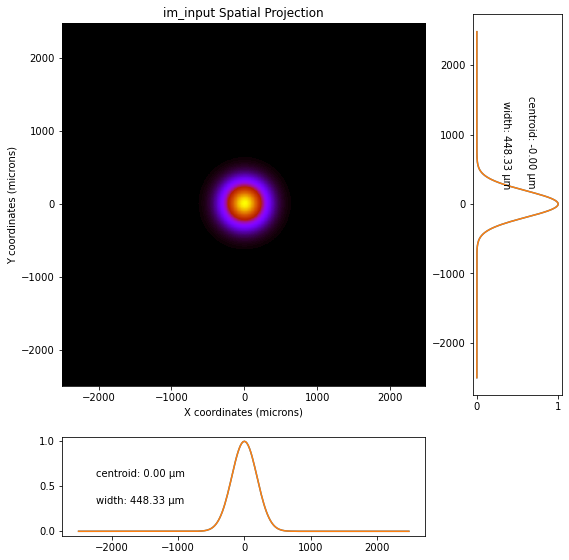

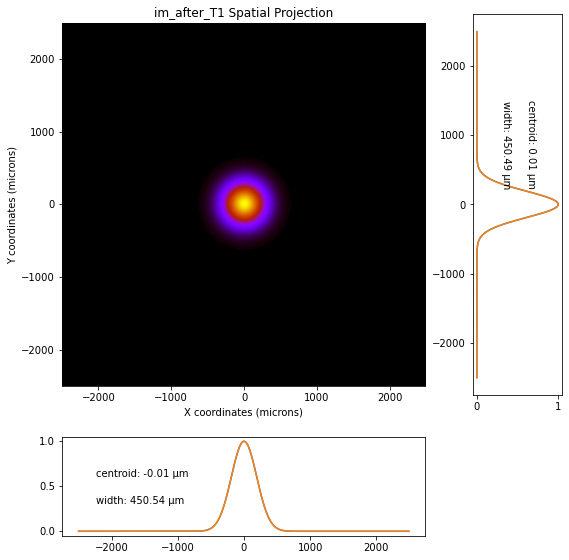

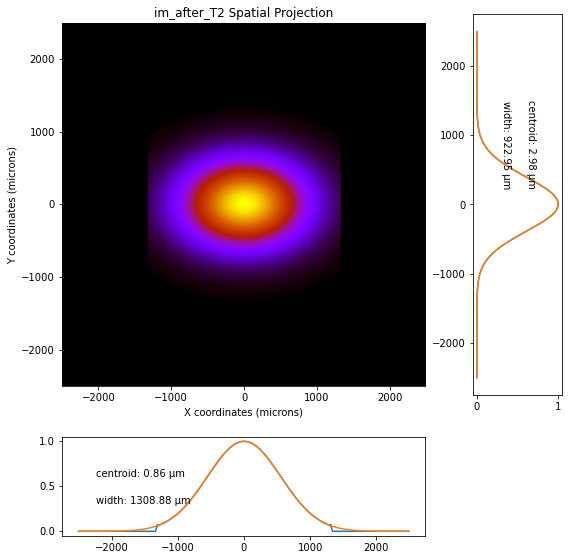

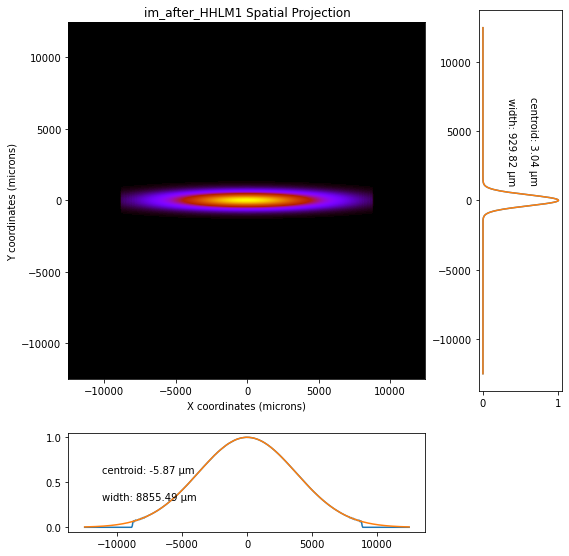

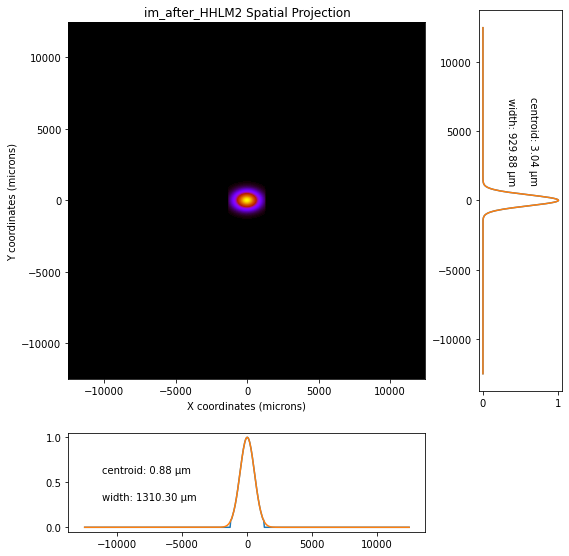

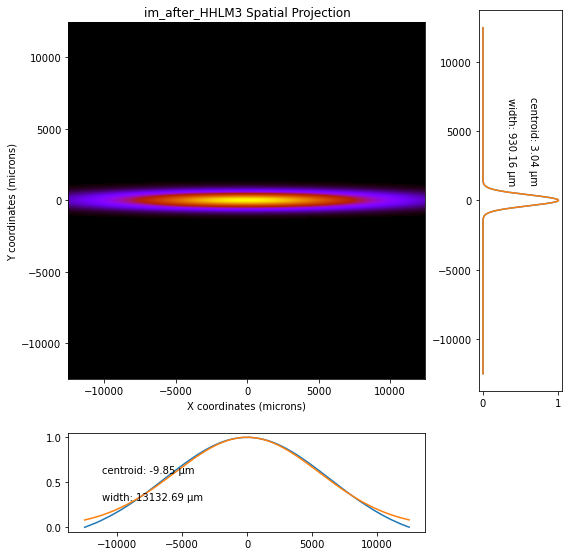

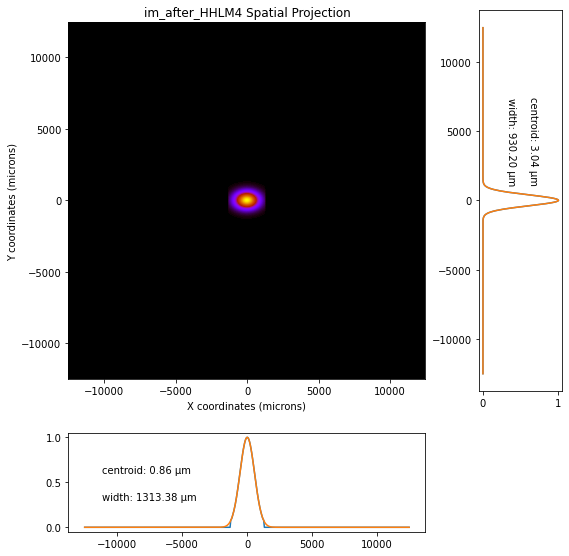

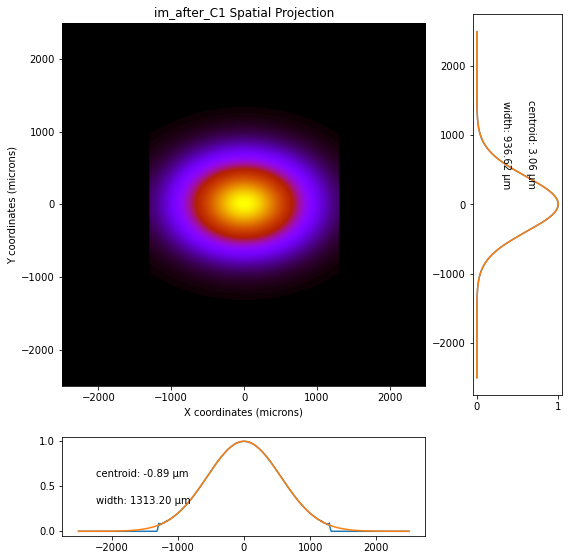

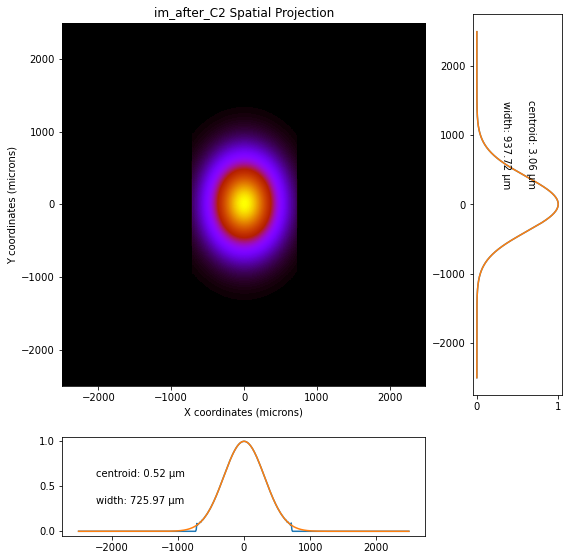

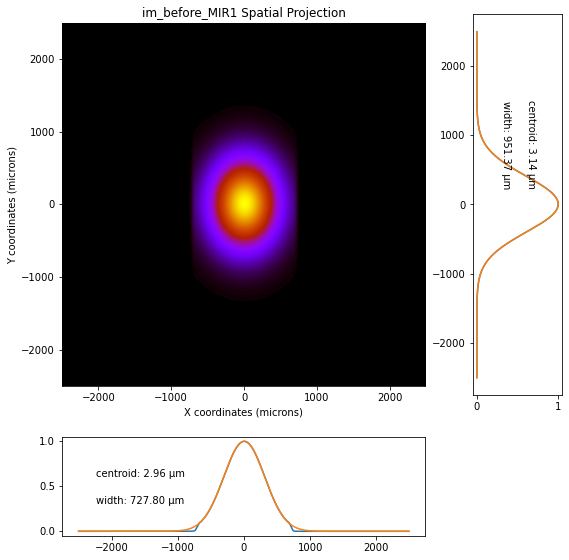

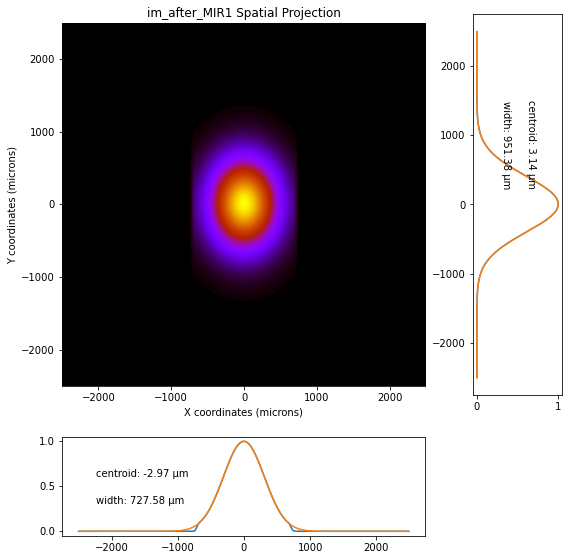

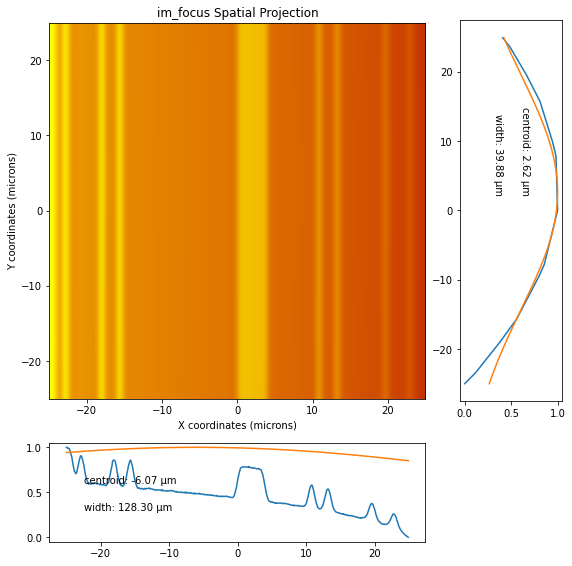

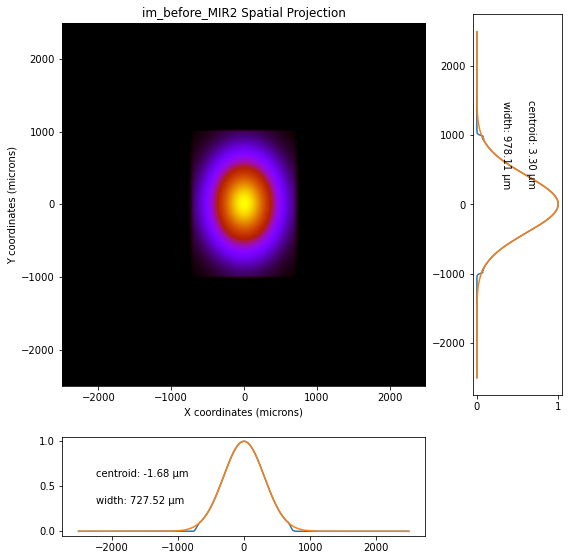

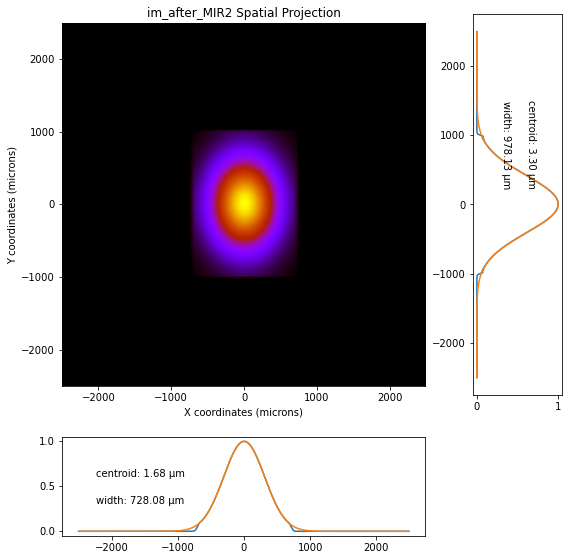

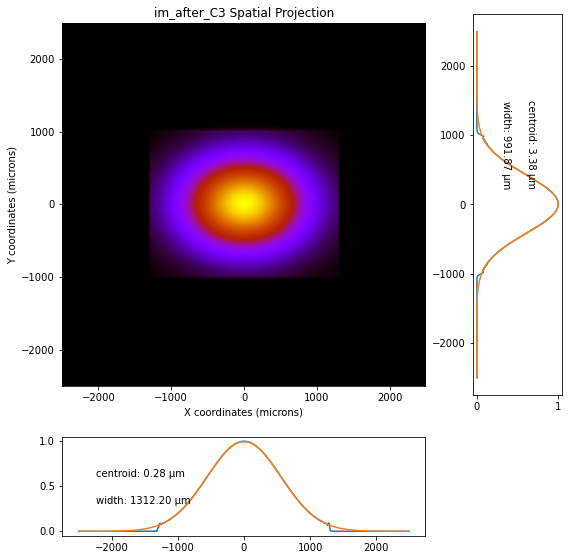

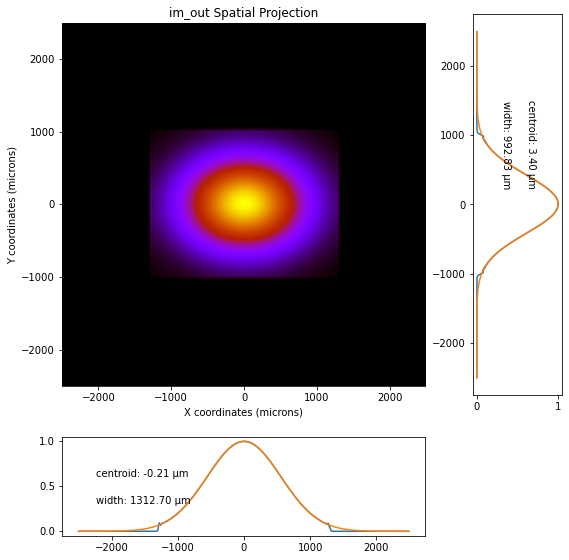

In [12]:
''' projection '''
dir_perfect = dir_plot

for i,screen_name in enumerate(pulse.screens):
    try:
        pulse.imshow_projection(screen_name)
        plt.savefig(dir_perfect+'projection_{}.{}.png'.format(i+1,screen_name))
    except:
        print(screen_name, 'failed')

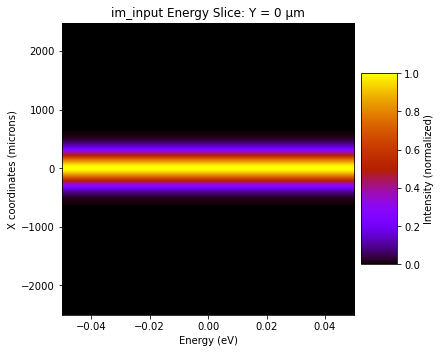

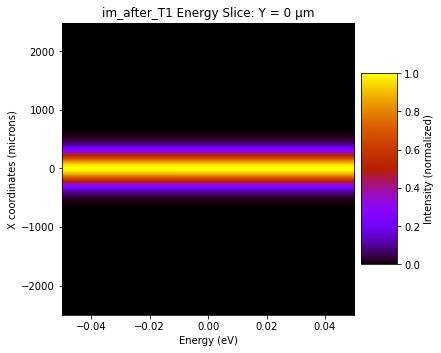

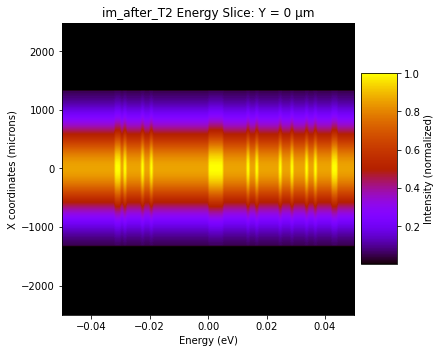

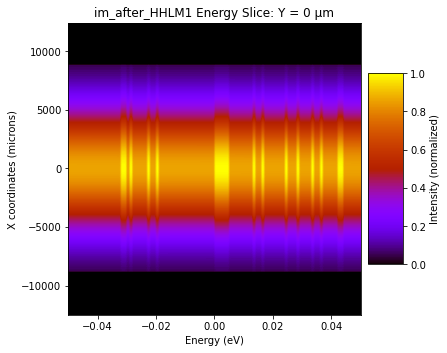

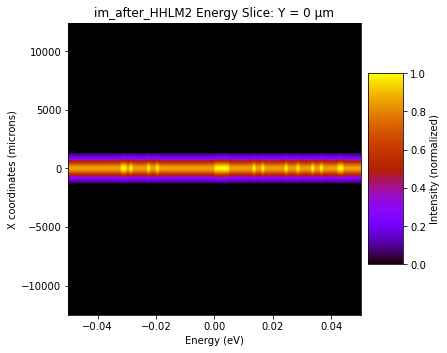

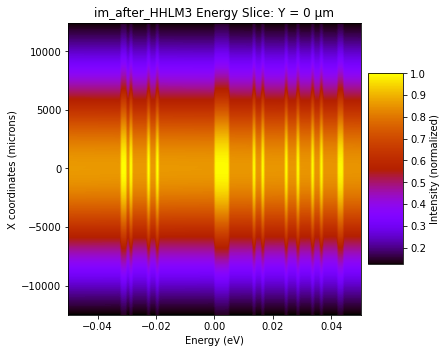

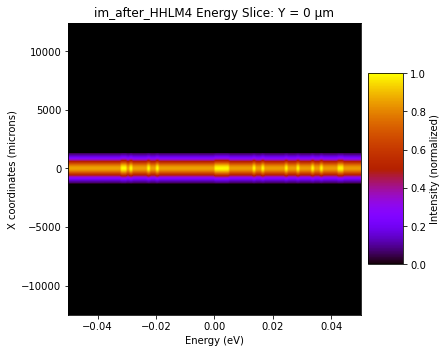

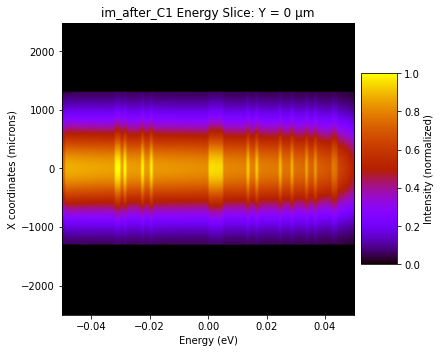

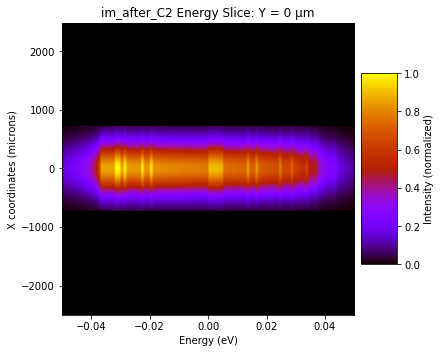

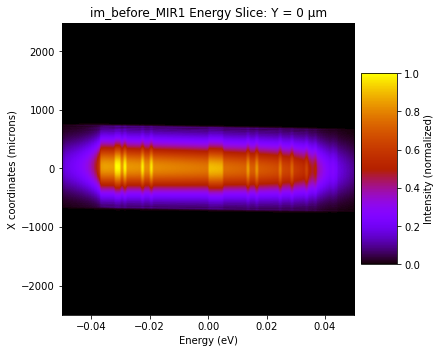

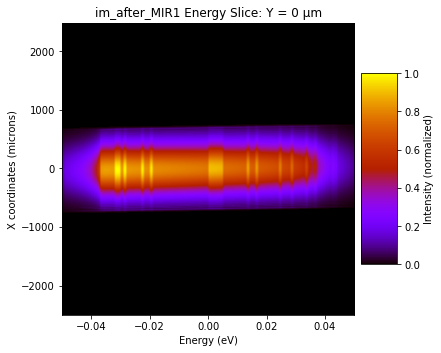

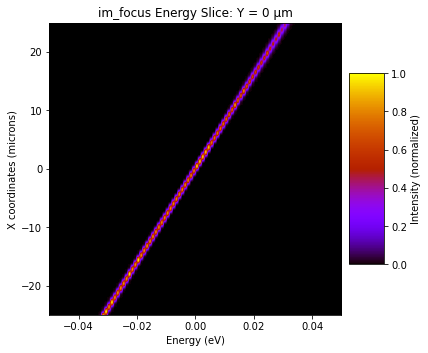

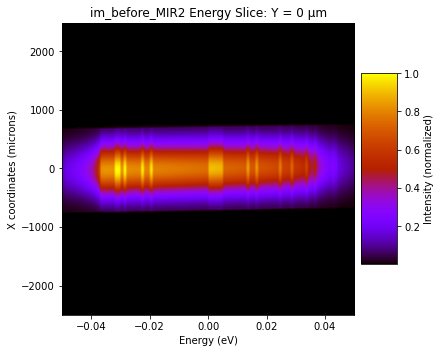

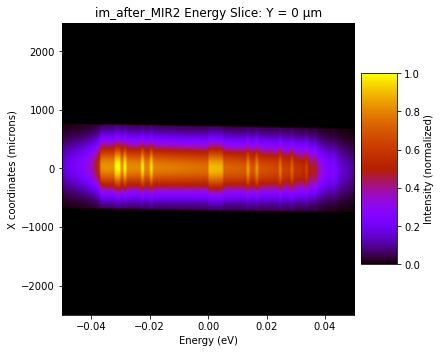

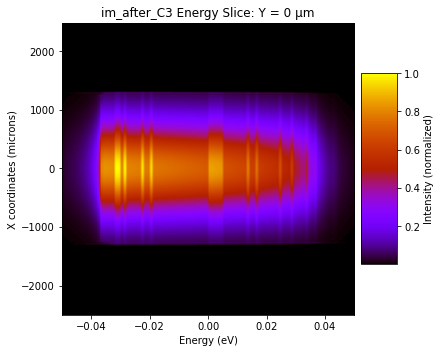

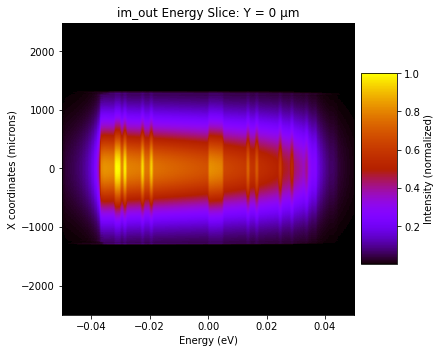

In [13]:
''' energy slices '''
for i,screen_name in enumerate(pulse.screens):
    try:
        pulse.imshow_energy_slice(screen_name)
        plt.savefig(dir_perfect+'spectrum_{}.{}.png'.format(i+1,screen_name))
    except:
        print(screen_name, 'failed')


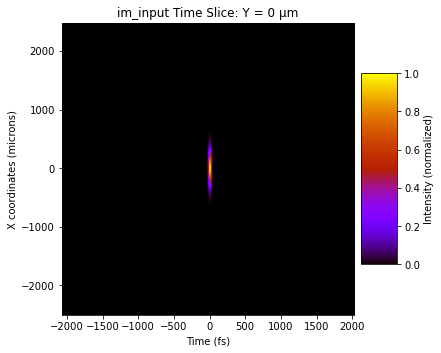

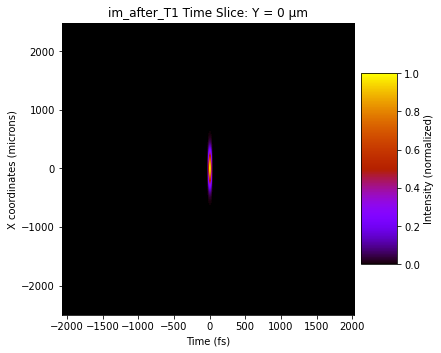

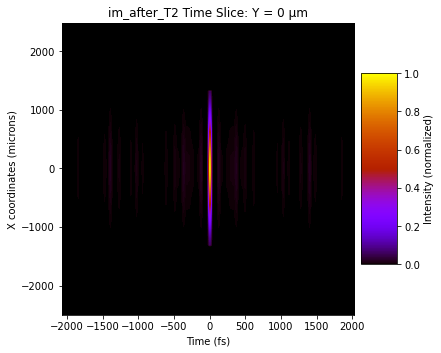

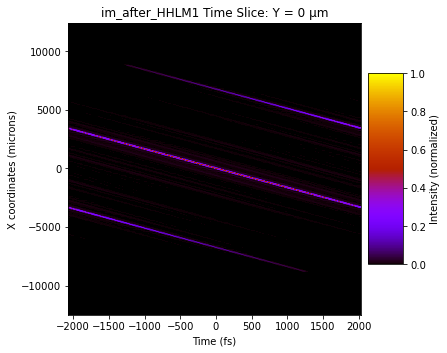

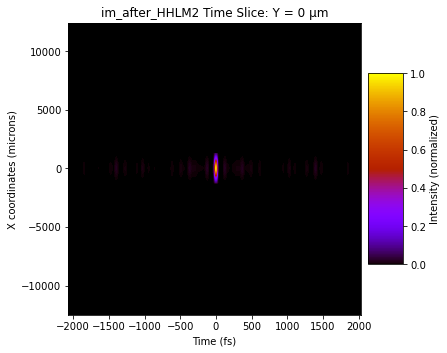

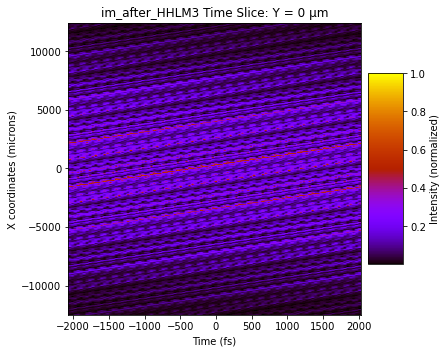

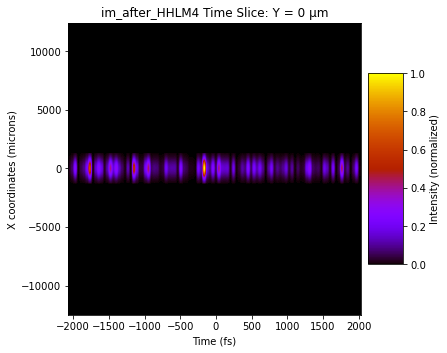

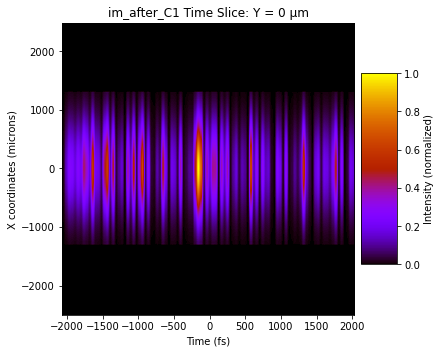

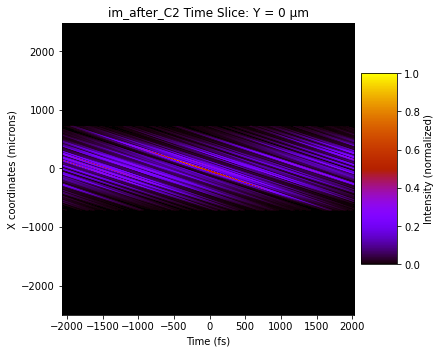

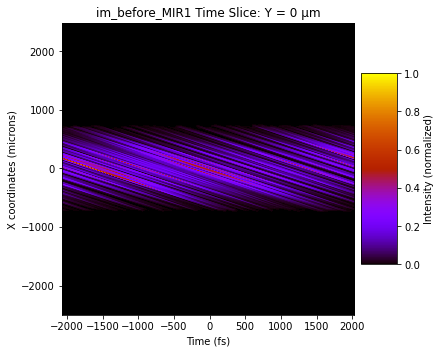

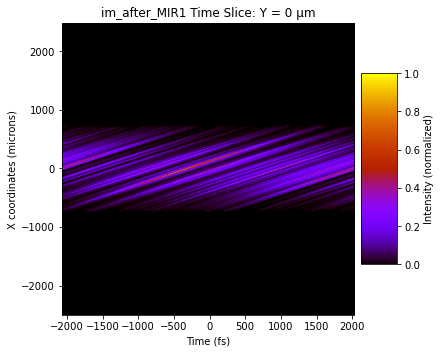

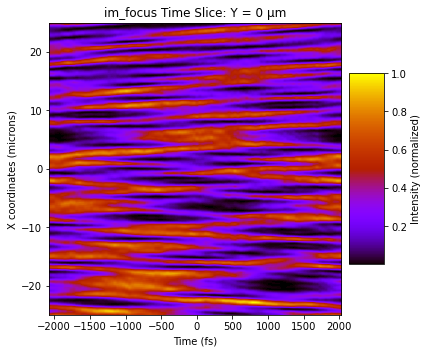

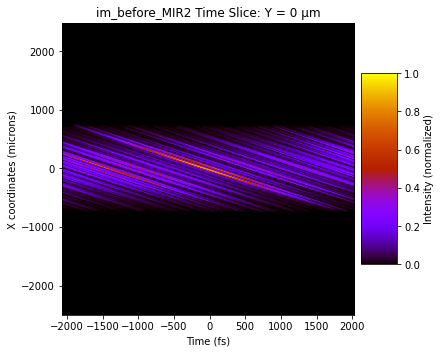

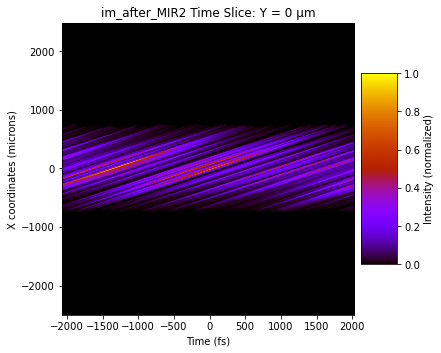

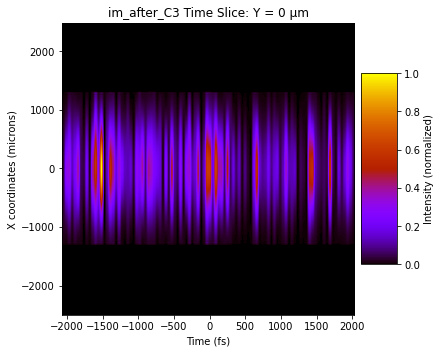

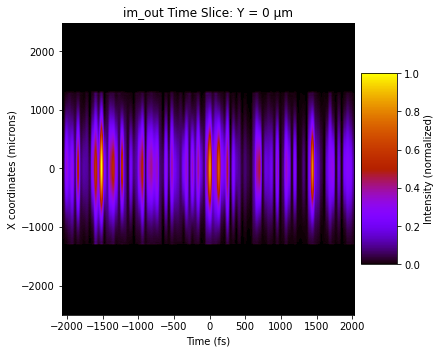

In [14]:
''' plot time slices '''
shift = 0
for i,screen_name in enumerate(pulse.screens):
    try:
        pulse.imshow_time_slice(screen_name, shift=shift)
        plt.savefig(dir_perfect+'tilt_{}.{}.png'.format(i+1,screen_name))
    except:
        print(screen_name, 'failed')

In [15]:
''' diagnostics '''
bandwidth = np.zeros_like(crystals)
for i,crystal in enumerate(crystals):
    screen_name = 'im_after_{}'.format(crystal)
    bandwidth[i] = pulse.pulse_bandwidth(screen_name)
    print(crystal, bandwidth[i])

c, pulse_duration0 = pulse.pulse_duration('im_out')
pulse_tilt0 = pulse.pulsefront_tilt('im_out')
spatial_chirp0 = pulse.spatial_chirp('im_out')
energy_bandwidth0 = pulse.pulse_bandwidth('im_out')
print('duration {}fs'.format(pulse_duration0))
print('tilt {}fs/um'.format(pulse_tilt0))
print('spatial chirp {}meV/um'.format(spatial_chirp0*1e3))
print('bandwidth {}meV'.format(energy_bandwidth0*1e3))

# np.savetxt(dir_perfect+'diagnostics_type.txt',np.array(['duration [fs]', 'tilt [fs/um]', 'chirp [meV/um]', 'bandwidth [meV]']), delimiter=',')
np.savetxt(dir_perfect+'diagnostics_value.txt',np.array([pulse_duration0, pulse_tilt0, spatial_chirp0*1e3, energy_bandwidth0*1e3]), delimiter=',')


HHLM1 1.455
HHLM2 1.032
HHLM3 0.718
HHLM4 0.585
C1 0.088
C2 0.068
duration 505fs
tilt 1.8455172778612707e-16fs/um
spatial chirp -4.850137478993002e-19meV/um
bandwidth 62.419740070688725meV


In [16]:
import winsound
winsound.Beep(1500, 3000)